# Elections et cartes électorales - correction

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Plan

Bidouiller les cartes électorales n'est pas facile mais il n'est pas nécessaire d'être très efficace pour orienter la décision dans un sens ou dans l'autre. L'idée principale consiste à bouger des électeurs d'une circoncription à l'autre pour favoriser les candidats d'un seul parti. Il faut que ces candidats sont élus avec une majorité suffisante tandis que les candidats adversaires doivent l'être avec une grande majorité. C'est une façon de donner plus d'importance aux voix d'un seul parti car elles annulent celles des autres. L'objectif visé est la préparation d'une prochaine élection à partir des résultats de la précédente sans que cela se voit trop. Mais nous pourrions essayer de faire basculer les résultats d'une élection dans un camp ou dans l'autre. Voici un exemple avec trois circonscriptions voisins et de taille équivalente.

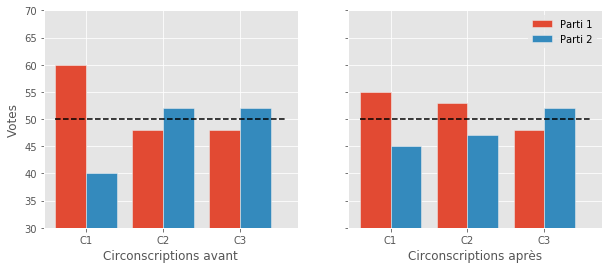

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,4))
ind = [1, 2, 3]
ind2 = [_ + 0.4 for _ in ind]
P1 = (60, 48, 48)
P2 = (40, 52, 52)
ax[0].bar(ind, P1, label="Parti 1", width=0.4)
ax[0].bar(ind2, P2, label="Parti 2", width=0.4)
ax[0].plot([1,4], [50, 50], "--", color="black")
ax[0].set_xlabel('Circonscriptions avant')
plt.setp(ax, xticks=ind2, xticklabels=('C1', 'C2', 'C3'))
P1 = (55, 53, 48)
P2 = (45, 47, 52)
ax[1].bar(ind, P1, label="Parti 1", width=0.4)
ax[1].bar(ind2, P2, label="Parti 2", width=0.4)
ax[1].plot([1,4], [50, 50], "--", color="black")
ax[1].set_xlabel('Circonscriptions après')
ax[0].set_ylabel('Votes')
plt.ylim([30, 70])
plt.legend()

**les moyens**

Nous ne connaissons pas les votes de chaque électeurs mais nous connaissons les résultats agrégés au niveau des bureaux de vote. Nous ne pouvons pas influencer les résultats de l'élection présidentielle car car les votes sont agrégées au niveau du pays : une voix à Perpignan compte autant d'une voix à Charleville. C'est différent pour les élections législatives. Un vote à Charleville n'a qu'un impact dans l'une des [577 circonscriptions](http://www.elections-legislatives.fr/circonscriptions.asp). Que se passe-t-il alors si on fait basculer un bureau de vote d'une circonscription à une autre ?

**la stratégie**

Travailler à plusieurs nécessite de répartir de travailler et d'isoler quelques fonctionnalités qui peuvent être développées en parallèle. Le premier besoin essentielle est celui de la **visualisation** des résultats. Nous allons faire beaucoup d'essais et il faut pouvoir rapidement visualiser le résultat afin d'éviter les erreurs visuellement évidentes. Comme tout projet, il faut un critère numérique qui permette de résumer la qualité d'une solution. Dans notre cas, celui-ci est relié aux nombres de députés élus venant du parti à favoriser. Le second besoin est l'**évaluation** d'une solution. Qu'est ce qui définit une solution ? Ce sont la description des circonscriptions, autrement l'appariement des bureaux de votes aux circonscriptions. Il faut réfléchir à un mécanisme qui nous permette de générer plusieurs solutions, plusieurs appariements. C'est l'étape de **génération** des solutions. C'est sans doute cette dernière partie qui sera la plus complexe car elle doit s'intéresser aux voisinages de bureaux de votes. On peut isoler un traitement spécifique qui consiste à calculer les **voisins** à regarder à partir d'une définition des circonscriptions.

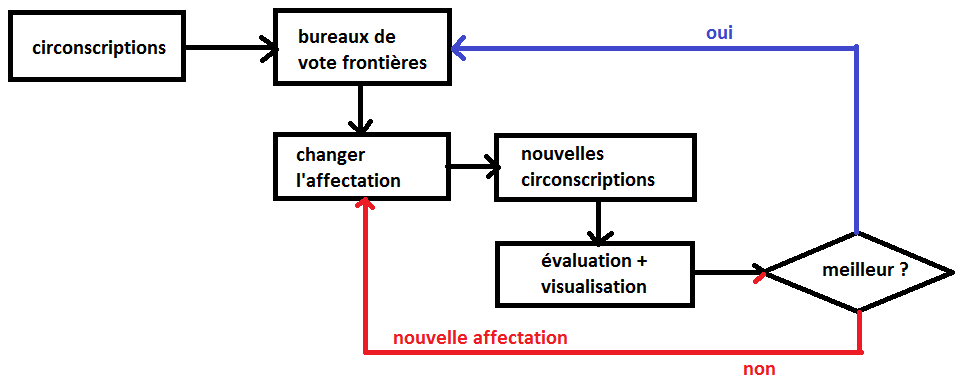

In [ ]:
from pyquickhelper.helpgen import NbImage
NbImage("gerrysol.png")

**travailler en commun**

Si chaque tâche, visualisation, évaluation, génération, peuvent être conçues en parallèle, il faut néanmoins réfléchir aux interfaces : il faut que chaque équipe sache sous quelle forme l'autre équipe va échanger des informations avec elle. Même si les données sont partagées par tout le monde et sont décrites dans des tables, il est préférable de préciser les colonnes importantes dans chacune d'entre elles. Par soucis de simplification, on ne s'intéresse qu'au second tour : la méthode ne s'adresse qu'au parti principaux et on fait l'hypothèse qu'ils sont en majorité présent au second tour.

* *résultat des élections* 

    * code département + code commune + code canton + bureau de vote = **identifiant bureau de vote**
    * **numéro circonscription**
    * inscrits
    * votants
    * exprimés
    * nuance du candidat
    * nombre de voix du candidat
    
* *geo* 

    * **code circonscription**
    * shape
    * **numero**
    
* *bureau_geo* 

    * **numero**
    * longitude
    * latitude
    
En gras, les champs qui serviront à faire des jointures. En second plan, il faut définir une façon commune de décrire les informations dont on a besoin tout au long de la chaîne de traitement :

* solution : un dictionnaire ``{ circonscription : [ liste des bureaux ] } ``
* bureaux fontières et voisins : un dictionnaire ``{ bureau : [ liste des bureaux voisins ] }``

**données manquantes**

La location des bureaux de votes n'est pas disponible pour tous les bureaux de votes. On ne pourra déplacer que ceux qu'on sait localiser.

## Données

On reprend les exemples de code fournis dans le notebook de l'énoncé.

* [Résultat des élections législatives françaises de 2012 au niveau bureau de vote](https://www.data.gouv.fr/fr/datasets/resultat-des-elections-legislatives-francaises-de-2012-au-niveau-bureau-de-vote-nd/)
* [Countours des circonscriptions des législatives](https://www.data.gouv.fr/fr/datasets/countours-des-circonscriptions-des-legislatives-nd/)
* [Localisation des buraux de votes](http://www.xavierdupre.fr/enseignement/complements/bureauxvotegeo.zip)
* [Localisation des villes](https://github.com/sdpython/actuariat_python/raw/master/src/actuariat_python/data/data_elections/villes_geo.zip)

In [ ]:
from actuariat_python.data import elections_legislatives_bureau_vote
tour = elections_legislatives_bureau_vote()
tour["T2"].sort_values(["Code département", "N° de circonscription Lg"]).head(n=2)

,N° tour,Code département,Code de la commune,Nom de la commune,N° de circonscription Lg,N° de canton,N° de bureau de vote,Inscrits,Votants,Exprimés,N° de dépôt du candidat,Nom du candidat,Prénom du candidat,Code nuance du candidat,Nombre de voix du candidat
3858,2,01,16,Arbigny,1,26,0001,309,146,144,32,BRETON,Xavier,UMP,87
3859,2,01,16,Arbigny,1,26,0001,309,146,144,33,DEBAT,Jean-François,SOC,57


In [ ]:
from actuariat_python.data import elections_legislatives_circonscription_geo
geo = elections_legislatives_circonscription_geo()
geo.sort_values(["department", "code_circonscription"]).head(n=2)

,code_circonscription,department,numero,communes,kml_shape,simple_form
11,01001,01,1,01053-01072-01106-01150-01177-01184-01195-0124...,<Polygon><outerBoundaryIs><LinearRing><coordin...,False
12,01002,01,2,01008-01047-01099-01202-01213-01224-01366-0138...,<Polygon><outerBoundaryIs><LinearRing><coordin...,True


In [ ]:
from actuariat_python.data import elections_vote_places_geo
bureau_geo = elections_vote_places_geo()
bureau_geo.head(n=2)

,address,city,n,place,zip,full_address,latitude,longitude,geo_address
0,cours verdun,bourg,1,salle des fêtes,1000,cours verdun 01000 bourg,46.206605,5.228364,"Cours de Verdun, Le Peloux, Les Vennes, Bourg-..."
1,cours verdun,bourg,2,salle des fêtes,1000,cours verdun 01000 bourg,46.206605,5.228364,"Cours de Verdun, Le Peloux, Les Vennes, Bourg-..."


## Statistiques

In [ ]:
t2 = tour["T2"]
t2.columns

Index(['N° tour', 'Code département', 'Code de la commune',
       'Nom de la commune', 'N° de circonscription Lg', 'N° de canton',
       'N° de bureau de vote', 'Inscrits', 'Votants', 'Exprimés',
       'N° de dépôt du candidat', 'Nom du candidat', 'Prénom du candidat',
       'Code nuance du candidat', 'Nombre de voix du candidat'],
      dtype='object')

Nous allons ajouter un identifiant pour les bureaux et les circonscriptions afin d'opérer des fusions entre données plus facilement. Comme l'objetif est de changer les bureaux de vote de circonscription, le code de la circonscription ne peut pas être utilisé pour identifier un bureau de vote. Nous allons vérifier que cette hypothèse tient la route.

In [ ]:
cols = ["Code département", "N° de canton", "N° de bureau de vote"]
def code_bureau(dd, aa, bb):
    bb = bb if isinstance(bb, str) else ("%03d" % bb)
    if len(bb) > 3: bb = bb[-3:]
    aa = aa if isinstance(aa, str) else ("%02d" % aa)
    dd = dd if isinstance(dd, str) else ("%02d" % dd)
    return "id" + dd + aa + bb
t2["idbureau"] = t2.apply(lambda row: code_bureau(*[row[c] for c in cols]), axis=1)
t2.head(n=2)

,N° tour,Code département,Code de la commune,Nom de la commune,N° de circonscription Lg,N° de canton,N° de bureau de vote,Inscrits,Votants,Exprimés,N° de dépôt du candidat,Nom du candidat,Prénom du candidat,Code nuance du candidat,Nombre de voix du candidat,idbureau
0,2,ZA,101,Les Abymes,1,1,0001,477,252,236,9,JALTON,Eric,SOC,182,idZA01001
1,2,ZA,101,Les Abymes,1,1,0001,477,252,236,17,DURIMEL,Harry,VEC,54,idZA01001


In [ ]:
t2["idcirc"] = t2.apply(lambda row: "id" + str(row["Code département"]) + "%03d" % row["N° de circonscription Lg"], axis=1)
t2.head(n=2)

,N° tour,Code département,Code de la commune,Nom de la commune,N° de circonscription Lg,N° de canton,N° de bureau de vote,Inscrits,Votants,Exprimés,N° de dépôt du candidat,Nom du candidat,Prénom du candidat,Code nuance du candidat,Nombre de voix du candidat,idbureau,idcirc
0,2,ZA,101,Les Abymes,1,1,0001,477,252,236,9,JALTON,Eric,SOC,182,idZA01001,idZA001
1,2,ZA,101,Les Abymes,1,1,0001,477,252,236,17,DURIMEL,Harry,VEC,54,idZA01001,idZA001


In [ ]:
len(set(t2["idcirc"]))

541

541 < 577 est inférieur au nombre de députés. Cela signifie que 577 - 541 députés ont été élus au premier tour. Il faut aller récupérer les données du premier tour pour ces circonscriptions.

In [ ]:
t2circ = set(t2["idcirc"])
t1 = tour["T1"]
t1["idcirc"] = t1.apply(lambda row: "id" + str(row["Code département"]) + "%03d" % row["N° de circonscription Lg"], axis=1)
t1["idbureau"] = t1.apply(lambda row: code_bureau(*[row[c] for c in cols]), axis=1)
t1["elu"] = t1["idcirc"].apply(lambda r: r not in t2circ)
t1nott2 = t1[t1["elu"]].copy()
t1nott2.head(n=2)

,N° tour,Code département,Code de la commune,Nom de la commune,N° de circonscription Lg,N° de canton,N° de bureau de vote,Inscrits,Votants,Exprimés,N° de dépôt du candidat,Nom du candidat,Prénom du candidat,Code nuance du candidat,Nombre de voix du candidat,idcirc,idbureau,elu
688,1,ZA,104,Baillif,4,36,0001,813,386,357,3,GUILLE,Marc,FN,4,idZA004,idZA36001,True
689,1,ZA,104,Baillif,4,36,0001,813,386,357,18,MOLINIE,Louis,DVD,6,idZA004,idZA36001,True


In [ ]:
len(set(t1nott2["idcirc"])) + 541

577

Il ne reste plus qu'à les ajouter aux données du second tour.

In [ ]:
import pandas
t1t2 = pandas.concat([t1nott2, t2], axis=0)

In [ ]:
statbu = t1t2[["Code département", "idcirc", "idbureau", 
               "Inscrits"]].groupby(["Code département", "idcirc", "idbureau"], as_index=False).max()
statbu.head()

,Code département,idcirc,idbureau,Inscrits
0,01,id01001,id0105003,967
1,01,id01001,id0105009,725
2,01,id01001,id0105013,1371
3,01,id01001,id0105014,1264
4,01,id01001,id0105017,1573


In [ ]:
statbu.sort_values("Inscrits", ascending=False).head(n=5)

,Code département,idcirc,idbureau,Inscrits
28013,ZZ,idZZ001,idZZ01001,156645
28020,ZZ,idZZ008,idZZ08001,109389
28018,ZZ,idZZ006,idZZ06001,106689
28021,ZZ,idZZ009,idZZ09001,97068
28016,ZZ,idZZ004,idZZ04001,96964


In [ ]:
"nombre de bureaux de vote", statbu.shape[0]

('nombre de bureaux de vote', 28024)

A priori, le département ``ZZ`` est une erreur. On vérifie.

In [ ]:
t1t2[t1t2["Code département"] == "ZZ"].head(n=2)

,Code de la commune,Code département,Code nuance du candidat,Exprimés,Inscrits,Nom de la commune,Nom du candidat,Nombre de voix du candidat,N° de bureau de vote,N° de canton,N° de circonscription Lg,N° de dépôt du candidat,N° tour,Prénom du candidat,Votants,elu,idbureau,idcirc
3789,1,ZZ,UMP,29223,156645,Amérique du Nord,LEFEBVRE,13441,0001,1,1,117,2,Frédéric,29869,NaN,idZZ01001,idZZ001
3790,1,ZZ,SOC,29223,156645,Amérique du Nord,NARASSIGUIN,15782,0001,1,1,143,2,Corinne,29869,NaN,idZZ01001,idZZ001


Ce bureau de vote n'est pas en France. Il est bien plus volumineux que les autres et nous ne pourrons pas le rapprocher géographiquement des autres. On n'en tiendra plus compte. On enlève également le bureau de vote ``ZW``.

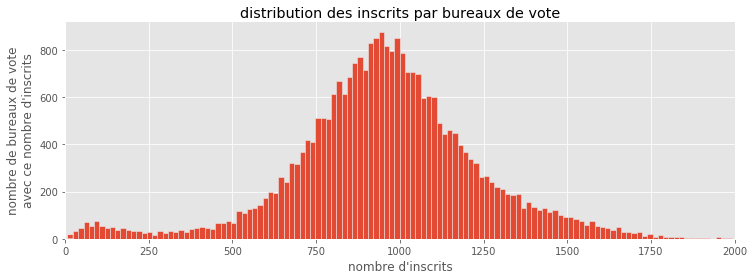

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
statbu[(statbu["Code département"] != "ZZ") & (statbu["Code département"] != "ZW")].hist( \
        bins=200, ax=ax)
ax.set_xlim(0, 2000)
ax.set_xlabel("nombre d'inscrits")
ax.set_ylabel("nombre de bureaux de vote\navec ce nombre d'inscrits")
ax.set_title("distribution des inscrits par bureaux de vote")

In [ ]:
nbbur = statbu[["idcirc","idbureau"]].groupby("idcirc").count()
nbbur.columns=["nombre de bureaux de vote"]
nbbur.head()

,nombre de bureaux de vote
idcirc,
id01001,30
id01002,28
id01003,26
id01004,27
id01005,36


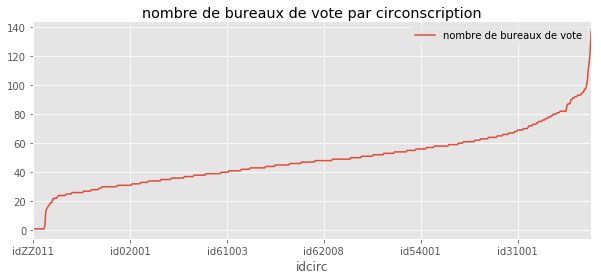

In [ ]:
ax = nbbur[nbbur[nbbur.columns[0]] > 0].sort_values(nbbur.columns[0]).plot(figsize=(10,4))
ax.set_title("nombre de bureaux de vote par circonscription")

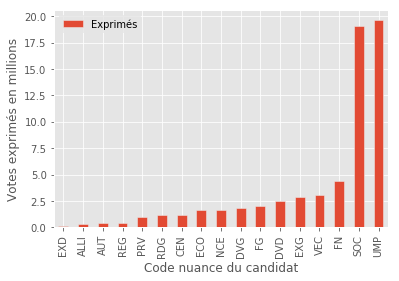

In [ ]:
t1t2noz = t1t2[(t1t2["Code département"] != "ZZ") & (t1t2["Code département"] != "ZW")]
elu = t1t2noz[["Code nuance du candidat", "Exprimés"]].groupby("Code nuance du candidat").sum()
ax = (elu.sort_values("Exprimés")/1000000).plot(kind="bar")
ax.set_ylabel("Votes exprimés en millions")

## Identifiants

Nous aurons besoin de croiser les données provenant de plusieurs bases en fonction des circonscriptions et des bureaux de votes. Il convient de déterminer ce qui identifient de façon unique un bureau de vote et une circonscription. Il faut se rappeler des conventions choisies :

* identifiant cironscription : **idDDCCC**, ``D`` pour code département, ``C`` pour code circonscription
* identifiant bureau de vote : **idDDAABBB**, ``D`` pour code département, ``C`` pour code circonscription, ``A`` pour code canton

In [ ]:
t1t2.head(n=2)

,Code de la commune,Code département,Code nuance du candidat,Exprimés,Inscrits,Nom de la commune,Nom du candidat,Nombre de voix du candidat,N° de bureau de vote,N° de canton,N° de circonscription Lg,N° de dépôt du candidat,N° tour,Prénom du candidat,Votants,elu,idbureau,idcirc
688,104,ZA,FN,357,813,Baillif,GUILLE,4,0001,36,4,3,1,Marc,386,True,idZA36001,idZA004
689,104,ZA,DVD,357,813,Baillif,MOLINIE,6,0001,36,4,18,1,Louis,386,True,idZA36001,idZA004


In [ ]:
len(set(t1t2["idcirc"]))

577

Le nombre de cirsconscription est le nombre attendu. On vérifie que les circonscriptions ne s'étendant pas sur plusieurs départements. Cela signifie que nous pouvons optimiser les répartitions des bureaux par département de façon indépendantes.

In [ ]:
t1t2.groupby(["idcirc", "Code département"], as_index=False).count().shape

(577, 18)

La ligne suivante montre qu'une circonscription englobe plusieurs cantons.

In [ ]:
t1t2.groupby(["idcirc", "N° de canton"], as_index=False).count().shape

(4171, 18)

## Evaluation d'une solution

Dans la suite, on se sert des deux colonnes ``idbureau`` et ``idcirc`` comme identifiant de bureaux et circonscription.

In [ ]:
import numpy

def agg_circonscription(data_vote, solution=None, 
                 col_circ="idcirc", col_place="idbureau", col_vote="Nombre de voix du candidat",
                 col_nuance="Code nuance du candidat"):
    """
    Calcul la nuance gagnante dans chaque circonscription.
    
    @param     data_vote    dataframe de type
    @param     solution     dictionnaire ``{ circonscription : liste de bureaux }``, 
                            si None considère la solution officielle
    @param     col_circ     colonne contenant la circonscription (si solution = None)
    @param     col_place    colonne contenant l'identifiant du bureaux de votes
    @param     col_vote     colonne contenant les votes
    @param     col_nuance   colonne contenant le parti ou la nuance
    @return                 matrice de résultats, une ligne par circoncription, une colonne par nuance/parti
    """
    if solution is None:
        agg = data_vote[[col_circ, col_nuance, col_vote]].groupby([col_circ, col_nuance], as_index=False).sum()
    else:
        rev = {}
        for k, v in solution.items():
            for place in v:
                if place in rev:
                    raise ValueError("Un bureaux est associé à deux circonscriptions : {0}".format([rev[place], k]))
                rev[place] = k
        keep = data_vote[[col_place, col_vote, col_nuance]].copy()
        keep[col_circ] = keep[col_place].apply(lambda r: rev[r])
        agg = keep[[col_circ, col_nuance, col_vote]].groupby([col_circ, col_nuance], as_index=False).sum()
        
    # les données sont maintenant agrégées par circonscription, il faut déterminer le gagnant
    piv = agg.pivot(col_circ, col_nuance, col_vote)
    gagnant = []
    votes = []
    sums = []
    
    for row in piv.values:
        mx = max((r, i) for i, r in enumerate(row) if not numpy.isnan(r))
        gagnant.append(piv.columns[mx[1]])
        votes.append(mx[0])
        sums.append(sum(r for r in row if not numpy.isnan(r)))
        
    piv["winner"] = gagnant
    piv["nbwinner"] = votes
    piv["total"] = sums
    return piv
     
score = agg_circonscription(t1t2noz)
score.head()

Code nuance du candidat,ALLI,AUT,CEN,DVD,DVG,ECO,EXD,EXG,FG,FN,NCE,PRV,RDG,REG,SOC,UMP,VEC,winner,nbwinner,total
idcirc,,,,,,,,,,,,,,,,,,,,
id01001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22743.0,24233.0,NaN,UMP,24233.0,46976.0
id01002,NaN,NaN,NaN,NaN,19529.0,NaN,NaN,NaN,NaN,8530.0,NaN,NaN,NaN,NaN,NaN,22327.0,NaN,UMP,22327.0,50386.0
id01003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15653.0,19266.0,NaN,UMP,19266.0,34919.0
id01004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19780.0,NaN,NaN,26175.0,NaN,UMP,26175.0,45955.0
id01005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17012.0,22008.0,NaN,UMP,22008.0,39020.0


In [ ]:
score.shape

(565, 20)

In [ ]:
len(set(t1t2noz["idcirc"]))

565

In [ ]:
len(set(t1t2["idcirc"]))

577

Le processus ne s'appliquera qu'aux circonscription de la métropole, soit 565. Le résultat d'une nouvelle répartition peut être calculée comme ceci :

In [ ]:
count = score[["winner", "nbwinner"]].groupby(["winner"]).count()
count.sort_values("nbwinner", ascending=False)

Code nuance du candidat,nbwinner
winner,
SOC,273
UMP,191
DVG,22
VEC,16
DVD,14
NCE,12
RDG,12
FG,10
PRV,6


## Visualisation d'une solution

### Première carte : circonscriptions actuelles

On reprend la même signature que la fonction précédente avec le dataframe ``geo`` qui contient la définition des circonscriptions. On commence par créer une fonction qui extrait les contours qui sont disponibles sous formes de chaînes de caractères. Le résultat est inspiré de ce [notebook](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/notebooks/td1a_cenonce_session_12.html#cartographie).

In [ ]:
def process_boundary(bound_string):
    ext = bound_string.split("<coordinates>")[-1].split("</coordinates>")[0]
    spl = ext.split(" ")
    return [(float(ll[0]), float(ll[1])) for ll in [_.split(",") for _ in spl]]

s = """
    <Polygon><outerBoundaryIs><LinearRing><coordinates>5.294455999999968,46.193934 5.279780999999957,46.201967</coordinates></LinearRing></outerBoundaryIs></Polygon>
    """
r = process_boundary(s)
r

[(5.294455999999968, 46.193934), (5.279780999999957, 46.201967)]

Certaines circonscriptions n'ont pas de contours.

In [ ]:
geo[geo.code_circonscription=="98702"]

,code_circonscription,department,numero,communes,kml_shape,simple_form
575,98702,987,2,NaN,NaN,True


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020843862DD8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000002085145F940>], dtype=object)

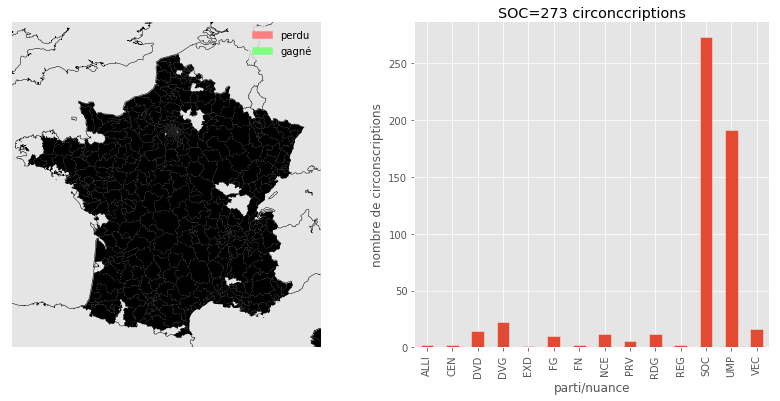

In [ ]:
from mpl_toolkits.basemap import Basemap
import numpy
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.patches as mpatches

def agg_circonscription_viz(thewinner, geo, data_vote, solution=None, 
                 col_circ="idcirc", col_place="idbureau", col_vote="Nombre de voix du candidat",
                 col_nuance="Code nuance du candidat", axes=None, figsize=(14,6), **kwargs):
    """
    Visualise la nuance gagnante dans chaque circonscription.
    
    @param     thewinner    parti qu'on souhaite influencer
    @param     geo          shapes pour chaque circonscription
    @param     axes         None ou deux systèmes d'axes
    @param     figsize      dimension du graphiques
    @param     kwargs       options additionnelles
    
    @param     data_vote    dataframe de type
    @param     solution     dictionnaire ``{ circonscription : liste de bureaux }``, 
                            si None considère la solution officielle
    @param     col_circ     colonne contenant la circonscription (si solution = None)
    @param     col_place    colonne contenant l'identifiant du bureaux de votes
    @param     col_vote     colonne contenant les votes
    @param     col_nuance   colonne contenant le parti ou la nuance
    @return                 matrice de resultat, une ligne par circoncription, une colonne par nuance/parti
    """
    # on transforme les dataframes en dictionnaires
    score = agg_circonscription(data_vote, solution=solution, 
                 col_circ=col_circ, col_place=col_place, col_vote=col_vote,
                 col_nuance=col_nuance)
    winner = score[["winner"]].to_dict("index")
    shapes = geo.set_index("code_circonscription")[["kml_shape"]].to_dict("index")
    
    if axes is None:
        # on créé des axes si non définis
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
    # on dessine la distribution des circonscriptions
    count = score[["winner", "nbwinner"]].groupby(["winner"]).count()
    count.sort_values("nbwinner", ascending=False)
    count.plot(ax=axes[1], kind="bar", legend=False)
    axes[1].set_xlabel("parti/nuance")
    axes[1].set_ylabel("nombre de circonscriptions")

    # on calcule le nombre de places le parti considéré
    count = count.reset_index(drop=False)
    count["iswin"] = count["winner"] == thewinner
    ratio = count[["nbwinner", "iswin"]].groupby("iswin").sum().sort_index()
    nbcirc = ratio.ix[1,0]
    axes[1].set_title("{0}={1} circonccriptions".format(thewinner, nbcirc))
    
    x1 = -5.0
    x2 = 9.
    y1 = 42.
    y2 = 52.    
    m = Basemap(resolution='i',projection='merc', 
                llcrnrlat=y1, urcrnrlat=y2, llcrnrlon=x1, urcrnrlon=x2, lat_ts=(x1+x2)/2,
                ax=axes[0])
    m.drawcountries(linewidth=0.5)
    m.drawcoastlines(linewidth=0.5)
    
    for circ, vals in shapes.items():
        if circ.startswith("Z") or circ.startswith("idZ"):
            # outside
            continue
        sh = vals["kml_shape"]
        if isinstance(sh, float):
            # NaN
            continue
        geo_points = process_boundary(sh)
        lons = [_[0] for _ in geo_points]
        lats = [_[1] for _ in geo_points]
        data = numpy.array(m(lons, lats)).T
        segs = [data,]
        lines = LineCollection(segs,antialiaseds=(1,))
        # pour changer les couleurs c'est ici, il faudra utiliser le champ records
        # pour les changer en fonction du nom du départements
        if circ in winner:
            win = winner[circ]["winner"]
            color = (0.5, 1.0, 0.5) if win == thewinner else (1.0, 0.5, 0.5)
        else:
            color = "black"            
        lines.set_facecolors(color)
        lines.set_edgecolors('k')
        lines.set_linewidth(0.1)
        axes[0].add_collection(lines)  

    red_patch = mpatches.Patch(color=(1.0, 0.5, 0.5), label='perdu')
    green_patch = mpatches.Patch(color=(0.5, 1.0, 0.5), label='gagné')
    axes[0].legend(handles=[red_patch, green_patch])        

    return axes
    
agg_circonscription_viz("SOC", geo, t1t2noz)

Certaines parties du territoires manquent. Les contours manquent ou les résultats manquent pour une certaine circonscription. La cohérence des données devraient être vérifiées car celles-ci viennent de sources différentes.

### Seconde carte : nouvelles circonscriptions

Si on change les circonscriptions, les contours des anciennes circonscriptions ne sont plus valables ! Si on ne dispose que de la position des bureaux de vote, il faut reconstruire le contour de chaque circonscription en fonction de la position des bureaux de vote. La méthode : construire un [graphe de Voronoï](https://fr.wikipedia.org/wiki/Diagramme_de_Vorono%C3%AF)
et ne garder que les frontières entre bureaux de circonscriptions différentes. Si on dispose de contour pour chaqeu bureau de vote, l'autre option consiste à fusionner ces contours en éliminant la surface commune. C'est ce que fait la fonction [cascade_union](http://toblerity.org/shapely/manual.html#shapely.ops.cascaded_union) du module [shapely](https://pypi.python.org/pypi/Shapely).

Le problème principal devient l'association de la location des bureaux de vote avec les résultats des votes.

In [ ]:
cols = ["city", "zip", "n"]
bureau_geo["idbureaugeo"] = bureau_geo.apply(lambda row: "-".join(str(row[_]) for _ in cols), axis=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002084DE16470>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000002084A875BA8>], dtype=object)

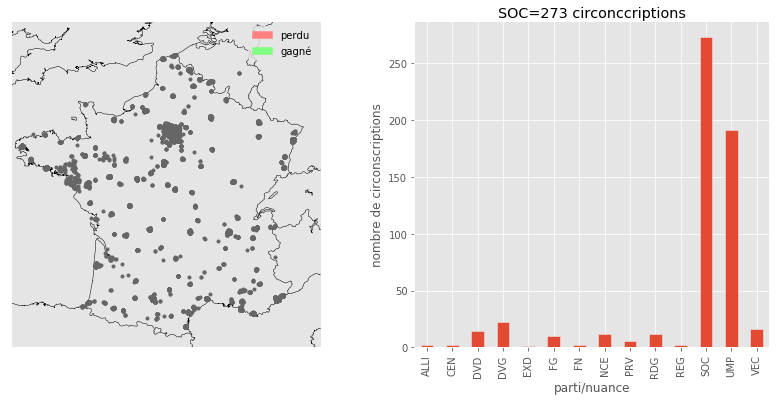

In [ ]:
def agg_bureau_viz(thewinner, bureau_geo, data_vote, solution=None, 
                 col_circ="idcirc", col_place="idbureau", col_vote="Nombre de voix du candidat",
                 col_nuance="Code nuance du candidat", axes=None, figsize=(14,6), **kwargs):
    """
    Visualise la nuance gagnante dans chaque circonscription.
    
    @param     thewinner    parti qu'on souhaite influencer
    @param     bureau_geo   positions des bureaux de votes
    @param     axes         None ou deux systèmes d'axes
    @param     figsize      dimension du graphiques
    @param     kwargs       options additionnelles
    
    @param     data_vote    dataframe de type
    @param     solution     dictionnaire ``{ circonscription : liste de bureaux }``, 
                            si None considère la solution officielle
    @param     col_circ     colonne contenant la circonscription (si solution = None)
    @param     col_place    colonne contenant l'identifiant du bureaux de votes
    @param     col_vote     colonne contenant les votes
    @param     col_nuance   colonne contenant le parti ou la nuance
    @return                 matrice de resultat, une ligne par circoncription, une colonne par nuance/parti
    """
    # on transforme les dataframes en dictionnaires
    score = agg_circonscription(data_vote, solution=solution, 
                 col_circ=col_circ, col_place=col_place, col_vote=col_vote,
                 col_nuance=col_nuance)
    winner = score[["winner"]].to_dict("index")
    buhsapes = bureau_geo.set_index("idbureaugeo")[["latitude", "longitude", "zip", "n"]].to_dict("index")
    
    if axes is None:
        # on créé des axes si non définis
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
    # on dessine la distribution des circonscriptions
    count = score[["winner", "nbwinner"]].groupby(["winner"]).count()
    count.sort_values("nbwinner", ascending=False)
    count.plot(ax=axes[1], kind="bar", legend=False)
    axes[1].set_xlabel("parti/nuance")
    axes[1].set_ylabel("nombre de circonscriptions")

    # on calcule le nombre de places le parti considéré
    count = count.reset_index(drop=False)
    count["iswin"] = count["winner"] == thewinner
    ratio = count[["nbwinner", "iswin"]].groupby("iswin").sum().sort_index()
    nbcirc = ratio.ix[1,0]
    axes[1].set_title("{0}={1} circonccriptions".format(thewinner, nbcirc))
    
    x1 = -5.0
    x2 = 9.
    y1 = 42.
    y2 = 52.    
    m = Basemap(resolution='i',projection='merc', 
                llcrnrlat=y1, urcrnrlat=y2, llcrnrlon=x1, urcrnrlon=x2, lat_ts=(x1+x2)/2,
                ax=axes[0])
    m.drawcountries(linewidth=0.5)
    m.drawcoastlines(linewidth=0.5)
    
    lons = bureau_geo["longitude"]
    lats = bureau_geo["latitude"]
    data = [m(x, y) for x,y in zip(lons, lats)]
    xs = [_[0] for _ in data]
    ys = [_[1] for _ in data]
    axes[0].plot(xs, ys, ".", color=(0.4, 0.4, 0.4))
        
    red_patch = mpatches.Patch(color=(1.0, 0.5, 0.5), label='perdu')
    green_patch = mpatches.Patch(color=(0.5, 1.0, 0.5), label='gagné')
    axes[0].legend(handles=[red_patch, green_patch])        

    return axes
    
agg_bureau_viz("SOC", bureau_geo, t1t2noz)

### Autres sources pour les bureaux de votes

La faible densité des bureaux de votes obligent à changer de jeu de données et d'utiliser celui de [cartelec](http://www.cartelec.net/?page_id=3609) uilisé pour l'année 2007.

In [ ]:
from pyensae.datasource import download_data
shp_vote = download_data("base_cartelec_2007_2010.zip")
import shapefile
r = shapefile.Reader("fond0710.shp")
shapes = r.shapes()
records = r.records()

In [ ]:
{k[0]:v for k,v in zip(r.fields[1:], records[0])}, shapes[0].points[:5]

({'BUREAU': '01001',
  'CANTON': 'CHATILLON-SUR-CHALARONNE',
  'CIRCO': '04',
  'CODE': '01001',
  'CODEARRT': '012',
  'CODECANT': '10',
  'CODEDEP': '01',
  'CODEREG': '82',
  'NOM': b"L'Abergement-Cl\xe9menciat"},
 [[846774.7025280485, 6563840.655779875],
  [847430.4726776106, 6566444.631470905],
  [848975.0615885032, 6566530.102978201],
  [849532.5253064571, 6565971.4588501565],
  [848969.0813380895, 6564398.911644492]])

In [ ]:
shapes[0].__dict__

{'bbox': [846774.7025280485, 6559575.068823495, 850941.7401535356, 6566530.102978201],
 'parts': [0],
 'points': [[846774.7025280485, 6563840.655779875],
  [847430.4726776106, 6566444.631470905],
  [848975.0615885032, 6566530.102978201],
  [849532.5253064571, 6565971.4588501565],
  [848969.0813380895, 6564398.911644492],
  [850941.7401535356, 6563209.5425065085],
  [849896.4212796891, 6562719.844144765],
  [849632.2745031306, 6561522.415193593],
  [849891.0276243397, 6560738.406460746],
  [848732.0257644501, 6559575.068823495],
  [848585.9032087281, 6560169.582690463],
  [847664.0345600601, 6560616.395794825],
  [847793.2580021, 6562243.125831007],
  [846774.7025280485, 6563840.655779875]],
 'shapeType': 5}

### Conversion des coordoonnées

Voir ce [notebook](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/notebooks/td1a_cenonce_session_12.html#cartographie). La fonction qui suit est assez longue exécutée un grand nombre de fois. Il faudrait l'accélérer avec [numba](http://numba.pydata.org/) ou [cython](http://cython.org/).

In [ ]:
import math
def lambert932WGPS(lambertE, lambertN):
    class constantes:
        GRS80E = 0.081819191042816
        LONG_0 = 3
        XS = 700000
        YS = 12655612.0499
        n = 0.7256077650532670
        C = 11754255.4261
    delX = lambertE - constantes.XS
    delY = lambertN - constantes.YS
    gamma = math.atan(-delX / delY)
    R = math.sqrt(delX * delX + delY * delY)
    latiso = math.log(constantes.C / R) / constantes.n
    sinPhiit0 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * math.sin(1)))
    sinPhiit1 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit0))
    sinPhiit2 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit1))
    sinPhiit3 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit2))
    sinPhiit4 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit3))
    sinPhiit5 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit4))
    sinPhiit6 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit5))
    longRad = math.asin(sinPhiit6)
    latRad = gamma / constantes.n + constantes.LONG_0 / 180 * math.pi
    longitude = latRad / math.pi * 180
    latitude = longRad / math.pi * 180
    return longitude, latitude
lambert932WGPS(99217.1, 6049646.300000001), lambert932WGPS(1242417.2, 7110480.100000001)

((-4.1615802638173065, 41.303505287589545),
 (10.699505053975292, 50.85243395553585))

In [ ]:
for shape in shapes:
    x1, y1 = lambert932WGPS(shape.bbox[0], shape.bbox[1])
    x2, y2 = lambert932WGPS(shape.bbox[2], shape.bbox[3])
    shape.bbox = [x1, y1, x2, y2]
    shape.points = [lambert932WGPS(x,y) for x,y in shape.points]

On réécrit la fonction qui dessine les bureaux de votes.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002080D4D0CF8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000002080D4F99E8>], dtype=object)

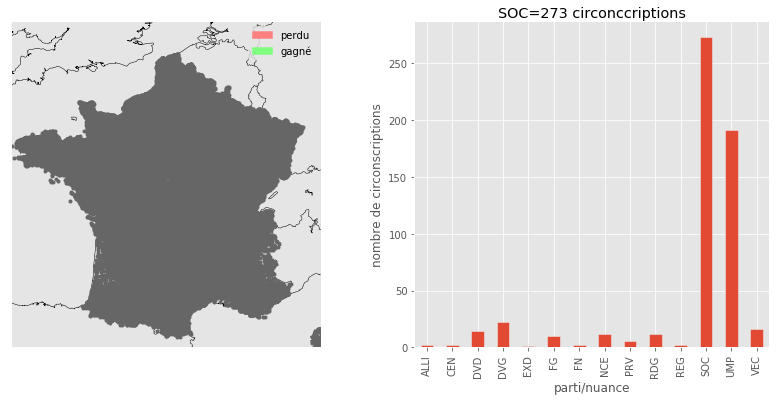

In [ ]:
def agg_bureau_shape_viz(thewinner, b_records, b_shapes, data_vote, solution=None, 
                 col_circ="idcirc", col_place="idbureau", col_vote="Nombre de voix du candidat",
                 col_nuance="Code nuance du candidat", axes=None, figsize=(14,6), **kwargs):
    """
    Visualise la nuance gagnante dans chaque circonscription.
    
    @param     thewinner    parti qu'on souhaite influencer
    @param     b_records    records des bureaux de vote
    @param     b_shapes     shapefile des bureaux de vote
    @param     axes         None ou deux systèmes d'axes
    @param     figsize      dimension du graphiques
    @param     kwargs       options additionnelles
    
    @param     data_vote    dataframe de type
    @param     solution     dictionnaire ``{ circonscription : liste de bureaux }``, 
                            si None considère la solution officielle
    @param     col_circ     colonne contenant la circonscription (si solution = None)
    @param     col_place    colonne contenant l'identifiant du bureaux de votes
    @param     col_vote     colonne contenant les votes
    @param     col_nuance   colonne contenant le parti ou la nuance
    @return                 matrice de resultat, une ligne par circoncription, une colonne par nuance/parti
    """
    # on transforme les dataframes en dictionnaires
    score = agg_circonscription(data_vote, solution=solution, 
                 col_circ=col_circ, col_place=col_place, col_vote=col_vote,
                 col_nuance=col_nuance)
    winner = score[["winner"]].to_dict("index")
    
    if axes is None:
        # on créé des axes si non définis
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
    # on dessine la distribution des circonscriptions
    count = score[["winner", "nbwinner"]].groupby(["winner"]).count()
    count.sort_values("nbwinner", ascending=False)
    count.plot(ax=axes[1], kind="bar", legend=False)
    axes[1].set_xlabel("parti/nuance")
    axes[1].set_ylabel("nombre de circonscriptions")

    # on calcule le nombre de places le parti considéré
    count = count.reset_index(drop=False)
    count["iswin"] = count["winner"] == thewinner
    ratio = count[["nbwinner", "iswin"]].groupby("iswin").sum().sort_index()
    nbcirc = ratio.ix[1,0]
    axes[1].set_title("{0}={1} circonccriptions".format(thewinner, nbcirc))
    
    x1 = -5.0
    x2 = 9.
    y1 = 42.
    y2 = 52.    
    m = Basemap(resolution='i',projection='merc', 
                llcrnrlat=y1, urcrnrlat=y2, llcrnrlon=x1, urcrnrlon=x2, lat_ts=(x1+x2)/2,
                ax=axes[0])
    m.drawcountries(linewidth=0.5)
    m.drawcoastlines(linewidth=0.5)
    
    lons = []
    lats = []
    for shape in b_shapes:
        x1, y1, x2, y2 = shape.bbox
        x = (x1+x2) / 2
        y = (y1+y2) / 2
        lons.append(x)
        lats.append(y)
    data = [m(x, y) for x,y in zip(lons, lats)]
    xs = [_[0] for _ in data]
    ys = [_[1] for _ in data]
    axes[0].plot(xs, ys, ".", color=(0.4, 0.4, 0.4))
        
    red_patch = mpatches.Patch(color=(1.0, 0.5, 0.5), label='perdu')
    green_patch = mpatches.Patch(color=(0.5, 1.0, 0.5), label='gagné')
    axes[0].legend(handles=[red_patch, green_patch])        

    return axes
    
agg_bureau_shape_viz("SOC", records, shapes, t1t2noz)

La France est recouvert de gris. La densité des bureaux de votes est plus conforme à celle attendue. La conversion des coordonnées a fonctionné.

### Fusionner les shapefiles

C'est maintenant qu'on va utiliser la fonction [cascade_union](http://toblerity.org/shapely/manual.html#shapely.ops.cascaded_union) du module [shapely](https://pypi.python.org/pypi/Shapely).
On extrait un sous-ensemble de bureaux de vote pour tester la fontion.

In [ ]:
canton04 = []
for rec, shape in zip(records, shapes):
    d = {k[0]:v for k,v in zip(r.fields[1:], rec)}
    if d["CODECANT"] == '10' and d['CODEDEP'] == '01':
        canton04.append((rec, shape))
len(canton04)

16

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002080D4BEA58>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000002080DB0C320>], dtype=object)

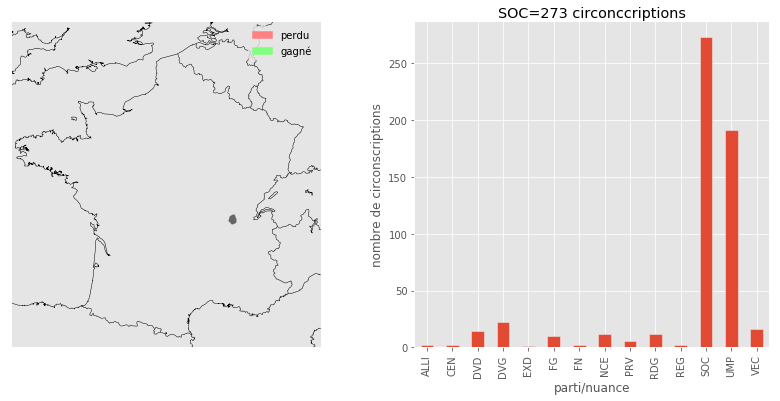

In [ ]:
agg_bureau_shape_viz("SOC", [_[0] for _ in canton04], [_[1] for _ in canton04], t1t2noz)

In [ ]:
from random import randint
colors = ['#%06X' % randint(0, 0xAAAAAA) for i in range(len(canton04))]

import folium
c = canton04[0][1]
map_osm = folium.Map(location=[c.bbox[1], c.bbox[0]])
from pyensae.notebook_helper import folium_html_map
i = 0
for rec, shape in canton04:
    d = {k[0]:v for k,v in zip(r.fields[1:], rec)}
    map_osm.add_child(folium.PolyLine(locations=shape.points, latlon=False, popup=str(d), color=colors[i]))
    i += 1
map_osm

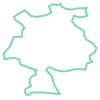

In [ ]:
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union
polys = []
for rec, shape in canton04:
    poly = Polygon([(x,y) for x,y in shape.points])
    polys.append(poly)
union = cascaded_union(polys)
union.boundary

In [ ]:
wk = union.boundary.xy
xs, ys = wk[0].tolist(), wk[1].tolist()
x0, y0 = xs[0], ys[0]
locations = list(zip(xs, ys))

In [ ]:
import folium
map_osm = folium.Map(location=[y0, x0])
from pyensae.notebook_helper import folium_html_map
map_osm.add_child(folium.PolyLine(locations=locations, latlon=False, popup=str(d), color="#000000"))
map_osm

### Carte finale après fusion des contours

Cette fusion repose sur la fonctionnalité que nous venons de présenter à savoir la fusion de deux contours. Il faut aussi pouvoir associer un contour avec la solution gagnante. Cette solution a pour format ``{ circonscription : [ liste des bureaux ] }``. On rappelle les identifiants choisis :

* identifiant cironscription : **DDCCC**, ``D`` pour code département, ``C`` pour code circonscription
* identifiant bureau de vote : **DDAABBB**, ``D`` pour code département, ``C`` pour code circonscription, ``A`` pour code canton

Example avec le premier bureau :

In [ ]:
d = {k[0]:v for k,v in zip(r.fields[1:], records[0])}
d

{'BUREAU': '01001',
 'CANTON': 'CHATILLON-SUR-CHALARONNE',
 'CIRCO': '04',
 'CODE': '01001',
 'CODEARRT': '012',
 'CODECANT': '10',
 'CODEDEP': '01',
 'CODEREG': '82',
 'NOM': b"L'Abergement-Cl\xe9menciat"}

#### fonction 1 : créer un dictionnaire avec les contours des bureaux de vote

Les shapes sont dans un tableau indicés par des entiers. Il sera plus simple de les indicés par leur identidiant.

In [ ]:
shape_bureau = {}
for rec, shape in zip(records, shapes):
    d = {k[0]:v for k,v in zip(r.fields[1:], rec)}
    idbureau = code_bureau(d["CODEDEP"], d["CODECANT"], d["BUREAU"][-3:])
    shape_bureau[idbureau] = (d, shape)

#### fonction 2 : fusionner tous les shapefiles

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 6.7934390152602466 47.502827122676621 at 6.7934390152602466 47.502827122676621
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 6.7934390152602466 47.502827122676621 at 6.7934390152602466 47.502827122676621


i 12 17
id2530C11
POLYGON ((6.793485118891656 47.5029647291152, 6.79387864984241 47.50246748159364, 6.794658337509125 47.50287801765317, 6.795471980407013 47.50326322290943, 6.796166649122362 47.50348276804262, 6.797005674854293 47.50372182100196, 6.798675164857242 47.504079093153, 6.798981964350904 47.50336672913484, 6.799272383858613 47.50342991080095, 6.799226821892461 47.50379468444716, 6.799914643536898 47.5039175547555, 6.79982999175596 47.5042351660605, 6.800623080319444 47.50433037799817, 6.801833772772055 47.50426663545223, 6.801962662923603 47.50406867370585, 6.802300349796412 47.50379123621479, 6.802992900129412 47.50347798876719, 6.80707357708312 47.50005081708112, 6.80676424331786 47.49972186128969, 6.806142147202308 47.49901562096665, 6.806139962818928 47.49848286793996, 6.806402842696771 47.49815942287386, 6.806869325880398 47.49768400396091, 6.807308748825132 47.49733056436382, 6.807598667165556 47.49688513511315, 6.807913428929112 47.49578496989378, 6.808114820160492 4

ValueError: No Shapely geometry can be created from null value

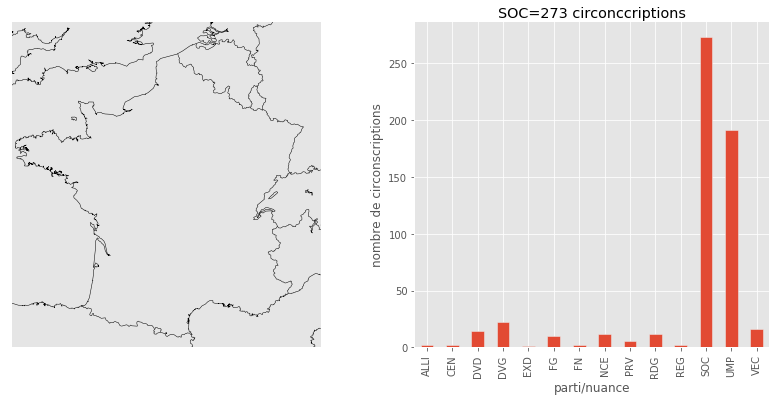

In [ ]:
from itertools import groupby

def new_agg_bureau_shape_viz(thewinner, shape_bureau, data_vote, solution=None, 
                 col_circ="idcirc", col_place="idbureau", col_vote="Nombre de voix du candidat",
                 col_nuance="Code nuance du candidat", axes=None, figsize=(14,6), **kwargs):
    """
    Visualise la nuance gagnante dans chaque circonscription.
    
    @param     thewinner    parti qu'on souhaite influencer
    @param     shape_bureau dictionnaire ``{ idbureau : (information, shapefile)}``
    @param     axes         None ou deux systèmes d'axes
    @param     figsize      dimension du graphiques
    @param     kwargs       options additionnelles
    
    @param     data_vote    dataframe de type
    @param     solution     dictionnaire ``{ circonscription : liste de bureaux }``, 
                            si None considère la solution officielle
    @param     col_circ     colonne contenant la circonscription (si solution = None)
    @param     col_place    colonne contenant l'identifiant du bureaux de votes
    @param     col_vote     colonne contenant les votes
    @param     col_nuance   colonne contenant le parti ou la nuance
    @return                 matrice de resultat, une ligne par circoncription, une colonne par nuance/parti
    """
    # on transforme les dataframes en dictionnaires
    score = agg_circonscription(data_vote, solution=solution, 
                 col_circ=col_circ, col_place=col_place, col_vote=col_vote,
                 col_nuance=col_nuance)
    winner = score[["winner"]].to_dict("index")
    
    # on récupère le mapping idbureau --> idcirc
    if solution is None:
        # pas de solution, on récupère la configuration existante
        gr = data_vote[["idcirc", "idbureau", "Code département"]].groupby(["idcirc", "idbureau"], as_index=False).count()
        gr = gr[["idcirc", "idbureau"]].sort_values("idcirc")
        solution = {}
        for k, g in groupby(gr.values, lambda d: d[0]):
            solution[k] = list(_[1] for _ in g)
    
    if axes is None:
        # on créé des axes si non définis
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
    # on dessine la distribution des circonscriptions
    count = score[["winner", "nbwinner"]].groupby(["winner"]).count()
    count.sort_values("nbwinner", ascending=False)
    count.plot(ax=axes[1], kind="bar", legend=False)
    axes[1].set_xlabel("parti/nuance")
    axes[1].set_ylabel("nombre de circonscriptions")

    # on calcule le nombre de places le parti considéré
    count = count.reset_index(drop=False)
    count["iswin"] = count["winner"] == thewinner
    ratio = count[["nbwinner", "iswin"]].groupby("iswin").sum().sort_index()
    nbcirc = ratio.ix[1,0]
    axes[1].set_title("{0}={1} circonccriptions".format(thewinner, nbcirc))
    
    # on s'occupe de la carte
    x1 = -5.0
    x2 = 9.
    y1 = 42.
    y2 = 52.    
    m = Basemap(resolution='i',projection='merc', 
                llcrnrlat=y1, urcrnrlat=y2, llcrnrlon=x1, urcrnrlon=x2, lat_ts=(x1+x2)/2,
                ax=axes[0])
    m.drawcountries(linewidth=0.5)
    m.drawcoastlines(linewidth=0.5)
    
    def dedup(ps):
        res = []
        for p in ps:
            if p not in res:
                res.append(p)
        return res
    
    for idcirc, idbureau in solution.items():        
        shapes = [shape_bureau[idb][1].points for idb in idbureau if idb in shape_bureau]
        if len(shapes) == 0:
            raise Exception("problem with " + idcirc)
        shapes = [Polygon(dedup([(x,y) for x,y in shape])) for shape in shapes if len(shape) > 0]
        try:
            union = cascaded_union(shapes)
        except Exception as e:
            for i in range(1, len(shapes)):
                try:
                    un = cascaded_union(shapes[:i])
                except Exception as e:
                    print("i", i-1, len(shapes))
                    print(idbureau[i-1])
                    print(shapes[i-1])
                    raise e
        lons = [_[0] for _ in union]
        lats = [_[1] for _ in union]
        data = numpy.array(m(lons, lats)).T
        segs = [data,]
        lines = LineCollection(segs,antialiaseds=(1,))
        # pour changer les couleurs c'est ici, il faudra utiliser le champ records
        # pour les changer en fonction du nom du départements
        if circ in winner:
            win = winner[circ]["winner"]
            color = (0.5, 1.0, 0.5) if win == thewinner else (1.0, 0.5, 0.5)
        else:
            color = "black"            
        lines.set_facecolors(color)
        lines.set_edgecolors('k')
        lines.set_linewidth(0.1)
        axes[0].add_collection(lines)  
        
    red_patch = mpatches.Patch(color=(1.0, 0.5, 0.5), label='perdu')
    green_patch = mpatches.Patch(color=(0.5, 1.0, 0.5), label='gagné')
    axes[0].legend(handles=[red_patch, green_patch])        

    return axes
    
new_agg_bureau_shape_viz("SOC", shape_bureau, t1t2noz)

## Construction des bureaux sur les frontières